In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

from xgboost import XGBClassifier

In [18]:
def clean_data_no_impute(df: pd.DataFrame) -> pd.DataFrame:
    """
    规则：
    1) 丢弃关键标签列缺失（这些列要做编码/是下游必需）
    2) 其他列的缺失值一律保留为 NaN（不做 0 填充），让 XGBoost 自行处理
    """
    key_fields = ["is_local","is_core","arpu","brand","gender","age","id_area"]
    df = df.dropna(subset=[c for c in key_fields if c in df.columns]).copy()
    # 不做任何 *_ltime/*_lflux 的填 0
    # 不做标准化；树模型不需要
    return df

def encode_known_categoricals(df: pd.DataFrame, cat_cols):
    """
    仅对明确的类别列做 LabelEncoder，确保这些列在上一步已无缺失。
    其余列（包含 NaN 的数值列）保持原样，交给 XGBoost 处理缺失。
    """
    encoders = {}
    for c in cat_cols:
        if c in df.columns:
            le = LabelEncoder()
            df[c] = le.fit_transform(df[c].astype(str))
            encoders[c] = le
    return df, encoders

In [19]:
# 路径（改成你的）
csv0 = "is_blue=0.csv"
csv1 = "is_blue=1.csv"

df0 = pd.read_csv(csv0)
df1 = pd.read_csv(csv1)
df = pd.concat([df0, df1], ignore_index=True)

# 清洗：不补 0
df_clean = clean_data_no_impute(df)

# 只编码我们确定是类别的列
cat_cols = ["is_local","is_core","brand","gender","id_area","age"]  # 如 age 连续，请从列表中移除
df_clean, encoders = encode_known_categoricals(df_clean, cat_cols)

# 目标与特征
assert "is_blue" in df_clean.columns, "缺少目标列 is_blue"
X = df_clean.drop(columns=["is_blue"])
y = df_clean["is_blue"].astype(int)

# 划分
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("训练集类别分布：", np.bincount(y_tr))
print("测试集类别分布：", np.bincount(y_te))

训练集类别分布： [ 258 3440]
测试集类别分布： [ 110 1475]


In [20]:
# 正负样本比例（neg/pos）
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / max(pos, 1)
scale_pos_weight

0.075

In [21]:
xgb = XGBClassifier(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",     # 更快
    missing=np.nan,         # 关键：显式告诉模型 NaN 是缺失
    scale_pos_weight=scale_pos_weight  # 处理不平衡
)

xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_te, y_te)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=600,
              n_jobs=None, num_parallel_tree=None, ...)

In [22]:
proba = xgb.predict_proba(X_te)[:, 1]
pred  = (proba >= 0.5).astype(int)

auc  = roc_auc_score(y_te, proba)
aupr = average_precision_score(y_te, proba)

print(f"AUC = {auc:.4f} | AUPRC = {aupr:.4f}")
print(classification_report(y_te, pred, digits=4))

AUC = 0.7201 | AUPRC = 0.9683
              precision    recall  f1-score   support

           0     0.3725    0.1727    0.2360       110
           1     0.9407    0.9783    0.9591      1475

    accuracy                         0.9224      1585
   macro avg     0.6566    0.5755    0.5976      1585
weighted avg     0.9012    0.9224    0.9089      1585



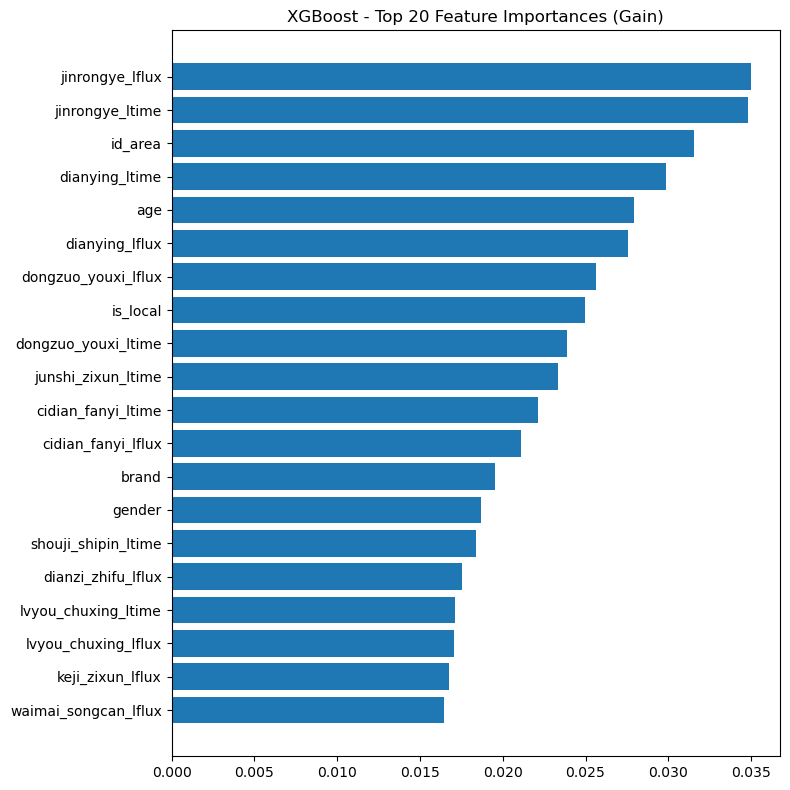

In [23]:
importances = xgb.feature_importances_  # 缺省为 'gain' 重要性（sklearn 接口）
fi = (pd.DataFrame({"feature": X.columns, "gain_importance": importances})
        .sort_values("gain_importance", ascending=False)
        .reset_index(drop=True))
fi.head(20)

# 简单条形图（不指定颜色/样式）
topk = 20
plt.figure(figsize=(8, 8))
plt.barh(fi.head(topk)["feature"][::-1], fi.head(topk)["gain_importance"][::-1])
plt.title(f"XGBoost - Top {topk} Feature Importances (Gain)")
plt.tight_layout()
plt.show()

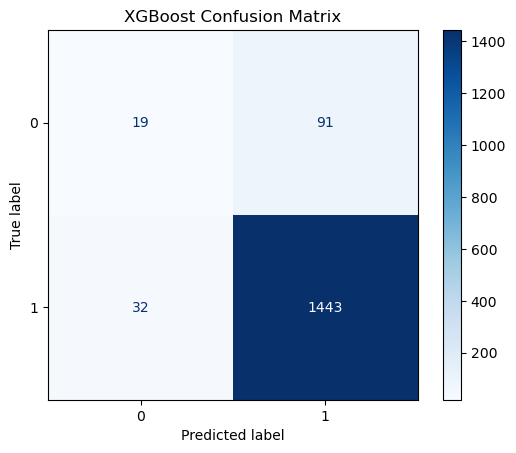

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- XGBoost混淆矩阵 ---
cm_xgb = confusion_matrix(y_te, pred) # 用 yte 而不是 y_test
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0,1])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix")
plt.show()